## Setup and imports

In [10]:
import os, sys
if os.path.exists("./src"):
    directory_to_prepend = os.path.abspath("./src")
else:
    raise RuntimeError("'src' is not in path")

print(f"-> src path found in: '{directory_to_prepend}")

if directory_to_prepend not in sys.path:
    sys.path = [directory_to_prepend] + sys.path

-> src path found in: '/Users/sofialuk/sampled-hnn/Sampling-HNNs/src


In [11]:
# Dataset visualization and plotting
import numpy as np
import matplotlib.pyplot as plt
from util import get_model_error
from data.three_body_orbit_generator import get_orbit, potential_energy, kinetic_energy, total_energy, figure8_config, brouckeA1_config, update_torch, update_np, state_to_coords_3body, coords2state_3body, xgroup_to_bodygroup, bodygroup_to_xgroup, orbit_state_to_coords12

# Model training
import torch
import pickle
from time import time
from hamiltonian import Hamiltonian
from model import Model
from model.sampled_network_type import SampledNetworkType
from trainer import Trainer, TrainerType, ParameterSampler
from data import get_train_test_set
from util import get_model_error
from logger import print_errors

np.random.seed(0)

## Dataset visualization

100%|██████████| 999/999 [00:00<00:00, 2244.21it/s]


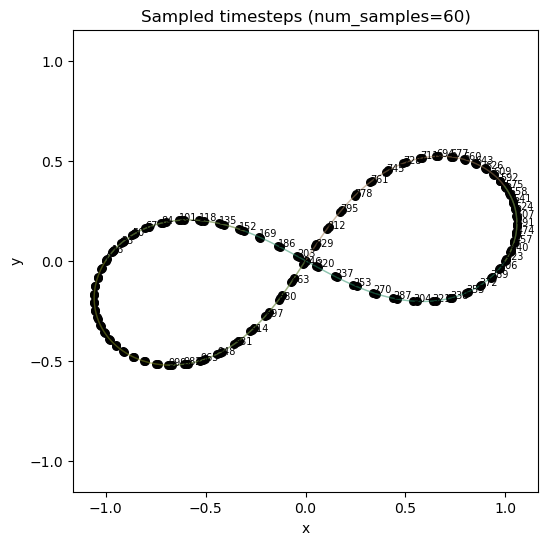

In [12]:
# Simulate figure-8
state_fig8 = figure8_config()
orbit_fig8, settings_fig8 = get_orbit(state_fig8, t_points=1000, t_span=[0,5])

# Positions
pos = orbit_fig8[:, 1:3, :]   # (3,2,1000)
t = settings_fig8["t_eval"]

# Choose how many sample points you want to visualize
num_samples = 60  # change to 10, 20, 50, 100, ...
sample_idx = np.linspace(0, 999, num_samples, dtype=int)

plt.figure(figsize=(6,6))

# Draw full path
for b in range(3):
    plt.plot(pos[b,0], pos[b,1], linewidth=1, alpha=0.3)

# Draw sampled dots
for i in sample_idx:
    for b in range(3):
        plt.scatter(pos[b,0,i], pos[b,1,i], s=30, color='black')

# Annotate timestep numbers
for i in sample_idx:
    x = pos[0,0,i]; y = pos[0,1,i]
    plt.text(x, y, f"{i}", fontsize=7)

plt.title(f"Sampled timesteps (num_samples={num_samples})")
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

100%|██████████| 999/999 [00:00<00:00, 2699.33it/s]


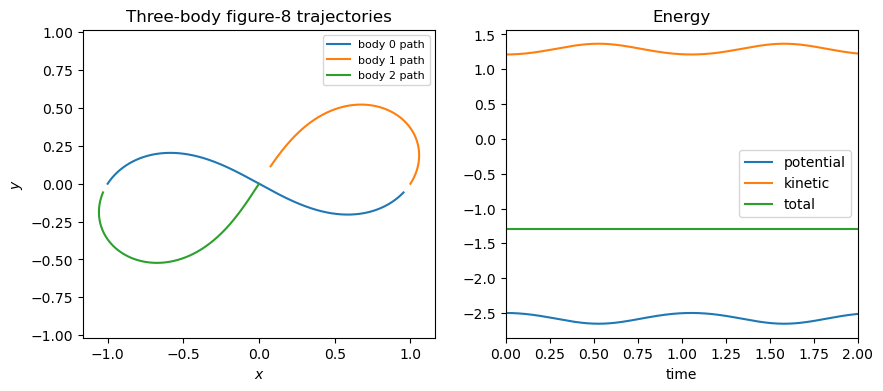

In [13]:
# one periodic figure-8 orbit
state_fig8 = figure8_config()
orbit_fig8, settings_fig8 = get_orbit(state_fig8, t_points=1000, t_span=[0,2])

# draw trajectories
fig = plt.figure(figsize=[10,4], dpi=100)
plt.subplot(1,2,1)
plt.title('Three-body figure-8 trajectories')
for i, path in enumerate(orbit_fig8):
    plt.plot(path[1], path[2], label='body {} path'.format(i))

plt.axis('equal')
plt.xlabel('$x$') ; plt.ylabel('$y$')
plt.legend(fontsize=8)

plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
plt.plot(settings_fig8['t_eval'], potential_energy(orbit_fig8), label='potential')
plt.plot(settings_fig8['t_eval'], kinetic_energy(orbit_fig8), label='kinetic')
plt.plot(settings_fig8['t_eval'], total_energy(orbit_fig8), label='total')
plt.legend()
plt.xlim(*settings_fig8['t_span'])

plt.savefig('plots/fig8_trajectories.pdf')
plt.show()

100%|██████████| 999/999 [00:00<00:00, 2160.94it/s]


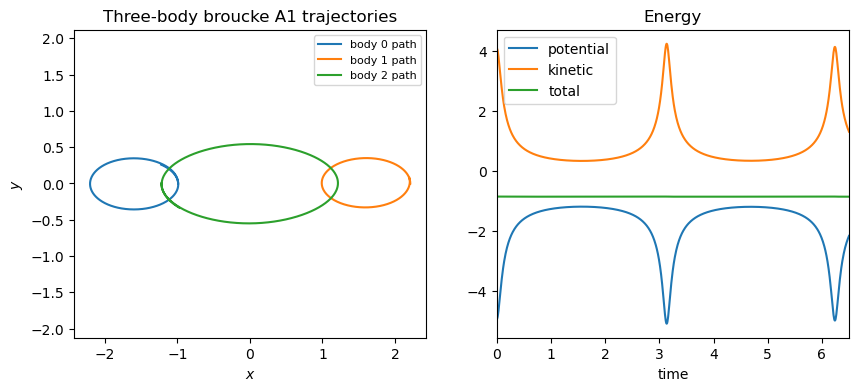

In [14]:
# one periodic figure-8 orbit
state_fig8 = brouckeA1_config()
orbit_fig8, settings_fig8 = get_orbit(state_fig8, t_points=1000, t_span=[0,6.5])

# draw trajectories
fig = plt.figure(figsize=[10,4], dpi=100)
plt.subplot(1,2,1)
plt.title('Three-body broucke A1 trajectories')
for i, path in enumerate(orbit_fig8):
    plt.plot(path[1], path[2], label='body {} path'.format(i))

plt.axis('equal')
plt.xlabel('$x$') ; plt.ylabel('$y$')
plt.legend(fontsize=8)

plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
plt.plot(settings_fig8['t_eval'], potential_energy(orbit_fig8), label='potential')
plt.plot(settings_fig8['t_eval'], kinetic_energy(orbit_fig8), label='kinetic')
plt.plot(settings_fig8['t_eval'], total_energy(orbit_fig8), label='total')
plt.legend()
plt.xlim(*settings_fig8['t_span'])

plt.savefig('plots/brouckeA1_trajectories.pdf')
plt.show()

## Network width and dataset size scaling experiments

In [15]:
SYSTEM = "figure-8" # "figure-8" or "broucke-A1"

In [16]:
DEFAULT_CONFIG = {
    "model": "S-HNN",
    "target": "three_body",
    "train_size": 10000,
    "test_size": 2000,
    "network_width": 1000,
    "activation": "tanh",
    "data_random_seed": 3943,
    "model_random_seed": 992472,
    "device": "cpu",  # or "cuda" if you have GPU
    "batch_size": 128,
    "total_steps": 10000,
    "learning_rate": 1e-3,
    "weight_decay": 1e-5,
    "sampling_type": SampledNetworkType.A_SWIM,
    "param_sampler": ParameterSampler.TANH,
    "rcond": 1e-13,
    "resample_duplicates": True,
}

def make_config(**overrides):
    """Return a training config with overrides applied."""
    cfg = DEFAULT_CONFIG.copy()
    cfg.update(overrides)
    return cfg

torch.set_default_dtype(torch.float64)

def train_model(trainer, model, inputs, dt_truths, x_0, x_0_H_truth, train_truths):
    print("Starting training...")
    t0 = time()
    trainer.train(
        model, inputs, dt_truths, x_0, x_0_H_truth, None, train_H_truths=train_truths
    )
    t1 = time()
    print(f"Training time: {t1 - t0:.2f} seconds\n")

### Experiment 1: Network Width vs Relative Error over 5 seeds

In [ ]:
WIDTH_LIST = [100, 200, 300, 400, 500, 700, 1000]
MASTER_SEED = 3943
NUM_SEEDS = 5

def width_training(model_name, sampler=SampledNetworkType.A_SWIM):
    master_rng = np.random.default_rng(MASTER_SEED)
    errors_w = {w: [] for w in WIDTH_LIST}
    cond_w = {w: [] for w in WIDTH_LIST}

    for width in WIDTH_LIST:
        print(f"\n===== WIDTH = {width} =====")

        for run in range(NUM_SEEDS):

            # --- Sample seeds for data + model ---
            data_seed  = master_rng.integers(0, 1e12)
            model_seed = master_rng.integers(0, 1e12)

            print(f" Run {run+1}/{NUM_SEEDS}  | data_seed={data_seed}, model_seed={model_seed}")
            param_sampler = ParameterSampler.TANH
            if (sampler == SampledNetworkType.ELM):
                param_sampler = ParameterSampler.A_PRIORI
            kwargs = make_config(model=model_name, sampling_type=sampler, network_width=width, data_random_seed=data_seed, model_random_seed=model_seed, param_sampler=param_sampler)

            # === Build model  ===
            input_dim, (q_lims, p_lims), target = Hamiltonian.new(**kwargs)
            kwargs["q_lims"] = q_lims
            kwargs["p_lims"] = p_lims
            kwargs["min_input"] = np.min([q_lims, p_lims])
            kwargs["max_input"] = np.max([q_lims, p_lims])
            model = Model.new(input_dim=input_dim, random_seed=model_seed, **kwargs)
            model.init_params()

            # === Generate dataset ===
            data_rng = np.random.default_rng(data_seed)
            (train_set, test_set) = get_train_test_set(input_dim // 2, target, kwargs["train_size"],
                                                        kwargs["test_size"], q_lims, p_lims, rng=data_rng)

            ((train_inputs,_), train_dt_truths, train_H_truths, train_H_grad_truths), \
                (train_x_0, train_x_0_H_truth) = train_set
            (test_inputs, test_dt_truths, test_H_truths, test_H_grad_truths) = test_set

            # --- Training ---
            if model.is_torch_model:
                trainer = Trainer.new(TrainerType.TRADITIONAL, **kwargs)
            else:
                trainer = Trainer.new(TrainerType.SAMPLER, **kwargs)

            train_truths = None
            if kwargs["sampling_type"] in [SampledNetworkType.SWIM]:
                train_truths = train_H_truths
            train_model(trainer, model, train_inputs, train_dt_truths, train_x_0, train_x_0_H_truth, train_truths)

            # === We want to later analyze condition number of S-HNN ===
            if model_name == "S-HNN":
                cond_w[width].append(trainer.cond_number)

            # === Evaluation ===
            train_errors = get_model_error(model, train_inputs, (train_dt_truths, train_H_truths, train_H_grad_truths))
            test_errors = get_model_error(model, test_inputs, (test_dt_truths, test_H_truths, test_H_grad_truths))
            print_errors(train_errors, test_errors)

            rel_H_error = test_errors[0] if kwargs["model"] in ["MLP", "S-MLP"] else test_errors[1]
            errors_w[width].append(rel_H_error)
            print(f"  Test error (H_rel) = {rel_H_error:.4e}")

    return errors_w, cond_w

#### S-HNN different sampling strategies

In [ ]:
errors_w_s_hnn, cond_w_s_hnn = width_training("S-HNN", SampledNetworkType.A_SWIM)

In [ ]:
errors_w_s_hnn_u, cond_w_s_hnn_u = width_training("S-HNN", SampledNetworkType.U_SWIM)

In [ ]:
errors_w_s_hnn_s, cond_w_s_hnn_s = width_training("S-HNN", SampledNetworkType.SWIM)

In [ ]:
errors_w_s_hnn_e, cond_w_s_hnn_e = width_training("S-HNN", SampledNetworkType.ELM)

#### S-MLP, MLP, HNN models

In [ ]:
errors_w_s_mlp, cond_w_s_mlp = width_training("S-MLP", SampledNetworkType.A_SWIM)

In [ ]:
errors_w_mlp, cond_w_mlp = width_training("MLP")

In [ ]:
errors_w_hnn, cond_w_hnn = width_training("HNN")

#### Plot network width vs relative test error figures

In [ ]:
# === All 4 models comparison === #

def mean_over_runs(errors_dict):
    widths = sorted(errors_dict.keys())
    means = [np.mean(errors_dict[w]) for w in widths]
    return widths, means

w1, e1 = mean_over_runs(errors_w_s_hnn)
w2, e2 = mean_over_runs(errors_w_hnn)
w3, e3 = mean_over_runs(errors_w_s_mlp)
w4, e4 = mean_over_runs(errors_w_mlp)

plt.figure()
plt.plot(w1, e1, marker="o", label="S-HNN (A-SWIM)")
plt.plot(w3, e3, marker="o", label="S-MLP (A-SWIM)")
plt.plot(w2, e2, marker="o", label="HNN")
plt.plot(w4, e4, marker="o", label="MLP")

plt.yscale("log")
plt.xlabel("Network Width")
plt.ylabel(r"Relative $L^2$ error, mean of 5 runs")
plt.legend()
plt.grid(True, which="both")
plt.savefig("plots/rel-error-vs-width-3-body-allmodels.pdf")
plt.show()

In [ ]:
# === All 4 sampling methods comparison === #

def mean_over_runs(errors_dict):
    widths = sorted(errors_dict.keys())
    means = [np.mean(errors_dict[w]) for w in widths]
    return widths, means

w1, e1 = mean_over_runs(errors_w_s_hnn)
w2, e2 = mean_over_runs(errors_w_s_hnn_s)
w3, e3 = mean_over_runs(errors_w_s_hnn_u)
w4, e4 = mean_over_runs(errors_w_s_hnn_e)

plt.figure()
plt.plot(w1, e1, marker="o", label="S-HNN (A-SWIM)")
plt.plot(w3, e3, marker="o", label="S-HNN (SWIM")
plt.plot(w2, e2, marker="o", label="S-HNN (U-SWIM)")
plt.plot(w4, e4, marker="o", label="S-HNN (ELM)")

plt.yscale("log")
plt.xlabel("Network Width")
plt.ylabel(r"Relative $L^2$ error, mean of 5 runs")
plt.legend()
plt.grid(True, which="both")
plt.savefig("plots/rel-error-vs-width-3-body-swim.pdf")
plt.show()

### Experiment 2: Dataset size vs Relative error over 5 seeds

In [ ]:
torch.set_default_dtype(torch.float64)

NETWORK_WIDTH = 1000
TRAIN_SIZES = [500, 1000, 5000, 10000, 15000]
MAX_TRAIN_SIZE = max(TRAIN_SIZES)

TEST_SIZE = 200  # fixed test size
NUM_SEEDS = 5
MASTER_SEED = 3943

def dataset_training(model_name, sampler=SampledNetworkType.A_SWIM):
    master_rng = np.random.default_rng(MASTER_SEED)

    errors_ts = {ts: [] for ts in TRAIN_SIZES}
    cond_ts = {ts: [] for ts in TRAIN_SIZES}

    # Build system once to extract input dimensions + limits
    # ---------------------------------------------------------
    tmp_input_dim, (q_lims, p_lims), target = Hamiltonian.new(model=model_name, target="three_body",
        train_size=1, test_size=1, network_width=NETWORK_WIDTH, activation="tanh")

    min_input = np.min([q_lims, p_lims])
    max_input = np.max([q_lims, p_lims])

    # Generate one full training set (size = MAX_TRAIN_SIZE)
    print(f"Generating shared training pool (size = {MAX_TRAIN_SIZE})...")
    TRAIN_SEED = master_rng.integers(0, 1e12)
    rng_full_train = np.random.default_rng(TRAIN_SEED)

    (full_train_set, test_set) = get_train_test_set(
        tmp_input_dim // 2,
        target,
        MAX_TRAIN_SIZE,  # single large dataset
        TEST_SIZE,  # ignored here
        q_lims,
        p_lims,
        rng=rng_full_train
    )

    (test_inputs, test_dt_truths, test_H_truths, test_H_grad_truths) = test_set
    ((full_inputs, _), full_dt_truths, full_H_truths, full_H_grad_truths), \
        (full_x0, full_x0_H_truth) = full_train_set

    #  Main experiment loop
    for train_size in TRAIN_SIZES:
        print("\n" + "=" * 80)
        print(f" Dataset size experiment: train_size = {train_size}, width = {NETWORK_WIDTH}")
        print("=" * 80)

        for run in range(NUM_SEEDS):

            data_seed = master_rng.integers(0, 1e12)
            model_seed = master_rng.integers(0, 1e12)

            print(f" Run {run + 1}/{NUM_SEEDS} | data_seed={data_seed}, model_seed={model_seed}")

            # --- Slice required training subset from large pool ---
            train_inputs = full_inputs[:train_size]
            train_dt_truths = full_dt_truths[:train_size]
            train_H_truths = full_H_truths[:train_size]
            train_H_grad_truths = full_H_grad_truths[:train_size]
            train_x_0 = full_x0
            train_x_0_H_truth = full_x0_H_truth

            param_sampler = ParameterSampler.TANH
            if (sampler == SampledNetworkType.ELM):
                param_sampler = ParameterSampler.A_PRIORI

            kwargs = make_config(model=model_name, train_size=train_size, test_size=TEST_SIZE,
                                 data_random_seed=data_seed, model_random_seed=model_seed, sampling_type=sampler, network_width=width, param_sampler=param_sampler, q_lims=q_lims, p_lims=p_lims,
                                 min_input=min_input, max_input=max_input)

            # --- Build model ---
            model = Model.new(input_dim=tmp_input_dim, random_seed=model_seed, **kwargs)
            model.init_params()

            # --- Trainer selection ---
            if model.is_torch_model:
                trainer = Trainer.new(TrainerType.TRADITIONAL, **kwargs)
            else:
                trainer = Trainer.new(TrainerType.SAMPLER, **kwargs)

            train_truths = train_H_truths if kwargs["sampling_type"] == SampledNetworkType.SWIM else None
            train_model(trainer, model, train_inputs, train_dt_truths, train_x_0, train_x_0_H_truth, train_truths)

            if model_name == "S-HNN":
                cond_ts[train_size].append(trainer.cond_number)
                print(f"  Condition number of A (final): {trainer.cond_number:.3e}")

            # --- Evaluate on FIXED test set ---
            test_errors = get_model_error(model, test_inputs, (test_dt_truths, test_H_truths, test_H_grad_truths))
            rel_H_error = test_errors[0] if kwargs["model"] in ["MLP", "S-MLP"] else test_errors[1]

            errors_ts[train_size].append(rel_H_error)
            print(f"   Test error (H_rel) = {rel_H_error:.4e}")
    return errors_ts, cond_ts

#### S-HNN different sampling strategies

In [ ]:
errors_d_s_hnn, cond_d_s_hnn = dataset_training("S-HNN", SampledNetworkType.A_SWIM)

In [ ]:
errors_d_s_hnn_s, cond_d_s_hnn_s = dataset_training("S-HNN", SampledNetworkType.SWIM)

In [ ]:
errors_d_s_hnn_u, cond_d_s_hnn_u = dataset_training("S-HNN", SampledNetworkType.U_SWIM)

In [ ]:
errors_d_s_hnn_e, cond_d_s_hnn_e = dataset_training("S-HNN", SampledNetworkType.ELM)

#### S-MLP, MLP, HNN models

In [ ]:
errors_d_s_mlp, cond_d_s_mlp = dataset_training("S-MLP", SampledNetworkType.A_SWIM)

In [ ]:
errors_d_mlp, cond_d_mlp = dataset_training("MLP")

In [ ]:
errors_d_hnn, cond_d_hnn = dataset_training("HNN")

### Plot dataset size vs test error figures

In [ ]:
# All 4 sampling types comparison

def mean_over_runs(errors_dict):
    widths = sorted(errors_dict.keys())
    means = [np.mean(errors_dict[w]) for w in widths]
    return widths, means

w1, e1 = mean_over_runs(errors_d_s_hnn)
w2, e2 = mean_over_runs(errors_d_s_hnn_u)
w3, e3 = mean_over_runs(errors_d_s_hnn_s)
w4, e4 = mean_over_runs(errors_d_s_hnn_e)

init_conditions = [x / 200 for x in TRAIN_SIZES] # [500, 1000, 5000, 10000, 15000]

plt.figure()
plt.plot(init_conditions, e1, marker="o", label="S-HNN (A-SWIM)")
plt.plot(init_conditions, e2, marker="o", label="S-HNN (U-SWIM)")
plt.plot(init_conditions, e3, marker="o", label="S-HNN (SWIM)")
plt.plot(init_conditions, e4, marker="o", label="S-HNN (ELM)")

plt.yscale("log")
plt.xlabel("Initial Conditions of Training Set")
plt.ylabel(r"Relative $L^2$ error, mean of 5 runs")
plt.legend()
plt.grid(True, which="both")
plt.tight_layout()
plt.savefig("plots/rel-error-vs-dataset-3-body-swim.pdf")
plt.show()

In [ ]:
# Comparison all 4 models

def mean_over_runs(errors_dict):
    widths = sorted(errors_dict.keys())
    means = [np.mean(errors_dict[w]) for w in widths]
    return widths, means

w1, e1 = mean_over_runs(errors_d_s_hnn)
w2, e2 = mean_over_runs(errors_d_s_mlp)
w3, e3 = mean_over_runs(errors_d_hnn)
w4, e4 = mean_over_runs(errors_d_mlp)

init_conditions = [x / 200 for x in TRAIN_SIZES] # [500, 1000, 5000, 10000, 15000]

plt.figure()
plt.plot(init_conditions, e1, marker="o", label="S-HNN")
plt.plot(init_conditions, e2, marker="o", label="S-MLP")
plt.plot(init_conditions, e3, marker="o", label="HNN")
plt.plot(init_conditions, e4, marker="o", label="MLP")

plt.yscale("log")
plt.xlabel("Initial Conditions of Training Set")
plt.ylabel(r"Relative $L^2$ error, mean of 5 runs")
plt.legend()
plt.grid(True, which="both")
plt.tight_layout()
plt.savefig("plots/rel-error-vs-dataset-3-body-allmodels.pdf")
plt.show()

#### S-HNN both experiments overview of test error and condition number

In [ ]:
# Width sweep
widths = np.array(WIDTH_LIST)
width_means  = np.array([np.mean(errors_w_s_hnn[w]) for w in WIDTH_LIST])
width_stds   = np.array([np.std(errors_w_s_hnn[w]) for w in WIDTH_LIST])
width_cond_means = np.array([np.mean(cond_w_s_hnn[w]) for w in WIDTH_LIST])
width_cond_stds  = np.array([np.std(cond_w_s_hnn[w]) for w in WIDTH_LIST])

# Train-size sweep
train_sizes = np.array(TRAIN_SIZES)
train_means = np.array([np.mean(errors_d_s_hnn[ts]) for ts in TRAIN_SIZES])
train_stds  = np.array([np.std(errors_d_s_hnn[ts]) for ts in TRAIN_SIZES])
train_cond_means = np.array([np.mean(cond_d_s_hnn[ts]) for ts in TRAIN_SIZES])
train_cond_stds  = np.array([np.std(cond_d_s_hnn[ts]) for ts in TRAIN_SIZES])

# Optional: convert train size to number of initial conditions
train_inits = train_sizes / 200.0

# === Create 2D plot === #
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (1) Width vs Relative Error
ax = axes[0, 0]
ax.errorbar(widths, width_means, yerr=width_stds, marker='o', capsize=5)
ax.set_xscale("linear")
ax.set_yscale("log")
ax.set_xlabel("Network Width")
ax.set_ylabel("Relative Test Error")
ax.set_title("Width vs Relative Error")
ax.grid(True, which="both")

# (2) Width vs Condition Number
ax = axes[0, 1]
ax.errorbar(widths, width_cond_means, yerr=width_cond_stds, marker='o', capsize=5)
ax.set_yscale("log")
ax.set_xlabel("Network Width")
ax.set_ylabel("Condition Number of A")
ax.set_title("Width vs Condition Number")
ax.grid(True, which="both")

# (3) Train Size vs Relative Error
ax = axes[1, 0]
ax.errorbar(train_inits, train_means, yerr=train_stds, marker='o', capsize=5)
ax.set_yscale("log")
ax.set_xlabel("Number of Initial Conditions")
ax.set_ylabel("Relative Test Error")
ax.set_title(f"Train Size vs Relative Error (width={NETWORK_WIDTH})")
ax.grid(True, which="both")

# (4) Train Size vs Condition Number
ax = axes[1, 1]
ax.errorbar(train_inits, train_cond_means, yerr=train_cond_stds, marker='o', capsize=5)
ax.set_yscale("log")
ax.set_xlabel("Number of Initial Conditions")
ax.set_ylabel("Condition Number of A")
ax.set_title(f"Train Size vs Condition Number (width={NETWORK_WIDTH})")
ax.grid(True, which="both")

plt.tight_layout()
plt.savefig("plots/rel-error-broucke-A1.pdf")
plt.show()

## Train a model for trajectory simulation

In [18]:
torch.set_default_dtype(torch.float64)

MODEL_NAME = "S-HNN"

kwargs = {
    "model": MODEL_NAME,
    "target": "three_body",
    "train_size": 10000,
    "test_size": 2000,
    "network_width": 1000,
    "activation": "tanh",
    "data_random_seed": 3943,
    "model_random_seed": 992472,
    "device": "cpu",  # or "cuda" if you have GPU
    "batch_size": 128,
    "total_steps": 10000,
    "learning_rate": 1e-3,
    "weight_decay": 1e-5,
    "sampling_type": SampledNetworkType.A_SWIM,
    "param_sampler": ParameterSampler.TANH,
    "rcond": 1e-13,
    "resample_duplicates": True,
}

#  Build target Hamiltonian system
input_dim, (q_lims, p_lims), target = Hamiltonian.new(**kwargs)
kwargs["q_lims"] = q_lims
kwargs["p_lims"] = p_lims
kwargs["min_input"] = np.min([q_lims, p_lims])
kwargs["max_input"] = np.max([q_lims, p_lims])


#  Build S-HNN model
model = Model.new(input_dim=input_dim, random_seed=kwargs["model_random_seed"], **kwargs)
model.init_params()

#  Training data
rng = np.random.default_rng(kwargs["data_random_seed"])
(train_set, test_set) = get_train_test_set(input_dim // 2, target, kwargs["train_size"], kwargs["test_size"],
                                           q_lims, p_lims, rng=rng)

((train_inputs,_), train_dt_truths, train_H_truths, train_H_grad_truths), (train_x_0, train_x_0_H_truth) = train_set
(test_inputs, test_dt_truths, test_H_truths, test_H_grad_truths) = test_set

if model.is_torch_model:
    trainer = Trainer.new(TrainerType.TRADITIONAL, **kwargs)
else:
    trainer = Trainer.new(TrainerType.SAMPLER, **kwargs)

train_truths = None
if kwargs["sampling_type"] is SampledNetworkType.SWIM:
    train_truths = train_H_truths

train_model(trainer, model, train_inputs, train_dt_truths, train_x_0, train_x_0_H_truth, train_truths)


def print_dataset_stats(x, dxdt, Hvals, name="dataset"):
    x = np.asarray(x)
    dxdt = np.asarray(dxdt)
    Hvals = np.asarray(Hvals).reshape(-1)

    print(f"\n===== Stats for {name} =====")

    print(f"x:     min={x.min():.6g}   mean={x.mean():.6g}   max={x.max():.6g}")
    print(f"dx/dt: min={dxdt.min():.6g} mean={dxdt.mean():.6g} max={dxdt.max():.6g}")
    print(f"H(x):  min={Hvals.min():.6g} mean={Hvals.mean():.6g} max={Hvals.max():.6g}")

    print("==============================\n")

print_dataset_stats(train_inputs, train_dt_truths, train_H_truths, name="TRAIN")

print_dataset_stats(test_inputs, test_dt_truths, test_H_truths, name="TEST")

if kwargs["model"] == ["S-HNN"]:
    H_pred = model.H(train_inputs)
    dt_pred = model.dt(train_inputs)
    print_dataset_stats(train_inputs, dt_pred, H_pred, name="MODEL(train)")

train_errors = get_model_error(model, train_inputs, (train_dt_truths, train_H_truths, train_H_grad_truths))
test_errors = get_model_error(model, test_inputs, (test_dt_truths, test_H_truths, test_H_grad_truths))
print_errors(train_errors, test_errors)

[DataLoader] Detected ThreeBody system — loading orbit dataset...
[DataLoader] Loading ThreeBody orbit dataset...
Had a problem loading data from src/data/three-body-data/three_body-orbits-dataset.pkl. Rebuilding dataset...
[Config] num_orbits=60, num_steps=200, total=12000


100%|██████████| 199/199 [00:00<00:00, 1381.44it/s]


Full len 12000
Train len - 10000
Test len - 2000
Starting training...
Condition number of A: 31298452.87590602
Condition number of A: 11767486.96690554
Training time: 57.60 seconds


===== Stats for TRAIN =====
x:     min=-1.56534   mean=0.00118073   max=1.68535
dx/dt: min=-8.08755 mean=1.30571e-17 max=7.50218
H(x):  min=-1.39247 mean=-1.28044 max=-1.19434


===== Stats for TEST =====
x:     min=-1.52062   mean=0.00125242   max=1.68694
dx/dt: min=-6.99803 mean=1.15556e-17 max=6.49368
H(x):  min=-1.39247 mean=-1.28298 max=-1.19435


┌────────────────────────────────────────────────────────┐
│   Target             Train Errors        Test Errors   │
│ - x_dot     :        5.7956E-02          6.0416E-02    │
│ - H(x)      :        7.7299E-03          8.2226E-03    │
│ - H_grad(x) :        5.7956E-02          6.0416E-02    │
└────────────────────────────────────────────────────────┘ 



In [ ]:
# ---- Loss curve ----
if (model.is_torch_model):
    plt.figure(figsize=(6,4))
    plt.plot(trainer.loss_history)
    plt.yscale("log")
    plt.xlabel("Training Step")
    plt.ylabel("Loss (log scale)")
    plt.title("Training Loss (Log Scale)")
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.show()

#### Choose integrator

In [19]:
from scipy.integrate import solve_ivp
from integrator.implicit_midpoint import implicit_midpoint
from integrator.symplectic_euler import symplectic_euler


INTEGRATOR = "implicit_midpoint"  # options: "implicit_midpoint", "solve_ivp", "symplectic_euler"

#### Chosee *num_steps* and *dt* for integration

In [20]:
trajectory = None

num_steps = 3000
dt = 0.001
T = num_steps * dt
t_eval_pred = np.linspace(0, T, num_steps + 1)

if INTEGRATOR == "implicit_midpoint":
    state = figure8_config() # (3,5)
    #state = brouckeA1_config()
    x0_true = state_to_coords_3body(state)
    x0_model = xgroup_to_bodygroup(x0_true)
    x0 = torch.tensor(x0_model[None,:])
    trajectory_torch = implicit_midpoint(x0, lambda x: update_torch(x, model), dt=dt, num_steps=num_steps) # use 0.001 at max
    traj_pred_body = trajectory_torch[0].cpu().numpy()
    trajectory = np.array([bodygroup_to_xgroup(row) for row in traj_pred_body])
    print(trajectory)

elif INTEGRATOR == "solve_ivp":
    state = figure8_config()
    #state = brouckeA1_config()
    x0_true = state_to_coords_3body(state)
    x0_model = xgroup_to_bodygroup(x0_true)
    x0 = torch.tensor(x0_model[None, :], dtype=torch.float64)
    sol = solve_ivp(fun=lambda t, y: update_np(y, model), # numpy version
        t_span=(0, T), y0=x0_model,
        method="RK45", t_eval=t_eval_pred, rtol=1e-9, atol=1e-12
    )
    trajectory = np.array([bodygroup_to_xgroup(row) for row in sol.y.T])
    print(trajectory)

elif INTEGRATOR == "symplectic_euler":
    state = figure8_config()
    #state = brouckeA1_config()
    x0_true = state_to_coords_3body(state)
    x0_model = xgroup_to_bodygroup(x0_true)
    x0 = torch.tensor(x0_model[None,:])
    trajectory_torch = symplectic_euler(x0, lambda x: update_torch(x, model), dt=dt, num_steps=num_steps, scheme="q_first")
    traj_pred_body = trajectory_torch[0].cpu().numpy()
    trajectory = np.array([bodygroup_to_xgroup(row) for row in traj_pred_body])

print(trajectory.shape)

100%|██████████| 3000/3000 [00:00<00:00, 3364.20it/s]

[[-1.00000000e+00  1.00000000e+00  0.00000000e+00 ...  5.32727000e-01
   5.32727000e-01 -1.06545400e+00]
 [-9.99607981e-01  1.00036764e+00 -7.59658032e-04 ...  5.32695408e-01
   5.32705969e-01 -1.06548259e+00]
 [-9.99214975e-01  1.00073424e+00 -1.51926507e-03 ...  5.32662079e-01
   5.32683501e-01 -1.06550807e+00]
 ...
 [ 9.50958512e-01 -8.04490521e-01 -1.46467991e-01 ...  3.83370372e-01
   2.26516860e-01 -5.84682965e-01]
 [ 9.50584871e-01 -8.05223794e-01 -1.45361077e-01 ...  3.83042767e-01
   2.27504802e-01 -5.85333617e-01]
 [ 9.50210707e-01 -8.05956108e-01 -1.44254599e-01 ...  3.82714230e-01
   2.28488788e-01 -5.85979542e-01]]
(3001, 12)


### Plot predicted trajectory (left) with predicted orbit's total, kinetic and potential energy (right)

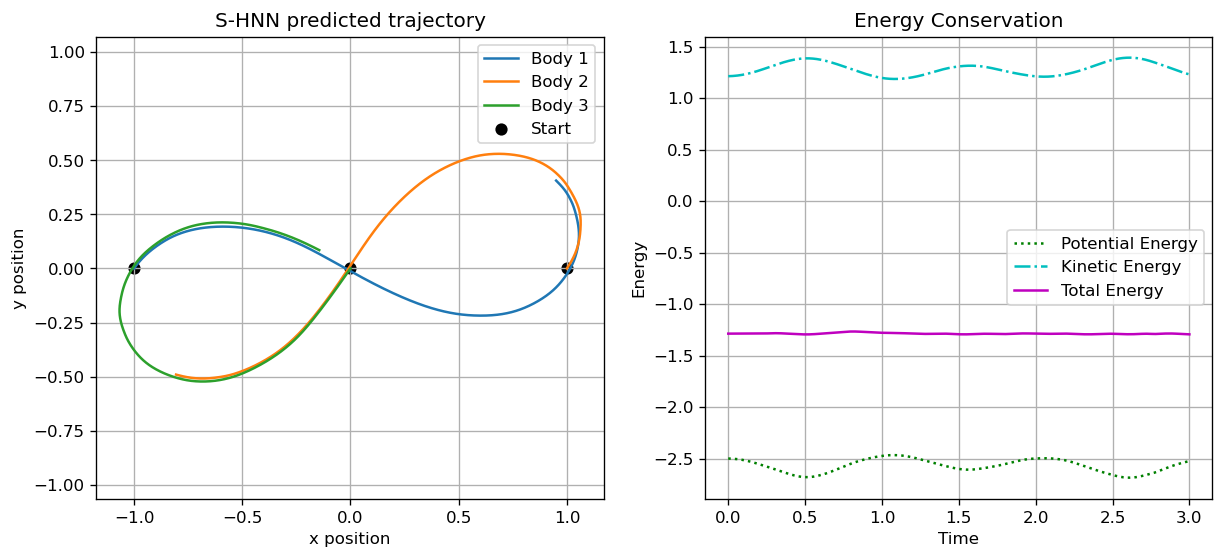

In [21]:
# Separate positions and momenta
qx1, qx2, qx3, qy1, qy2, qy3 = trajectory[:, 0:6].T
px1, px2, px3, py1, py2, py3 = trajectory[:, 6:12].T
num_steps = trajectory.shape[0] - 1     # 500
t_eval = np.linspace(0, T, num_steps + 1)
state = coords2state_3body(trajectory)
hnn_pe = potential_energy(state)
hnn_ke = kinetic_energy(state)
hnn_etot = total_energy(state)

# --- Plot trajectories and energies ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

# --- Orbit  ---
ax1.plot(qx1, qy1, label="Body 1")
ax1.plot(qx2, qy2, label="Body 2")
ax1.plot(qx3, qy3, label="Body 3")
ax1.scatter([qx1[0], qx2[0], qx3[0]], [qy1[0], qy2[0], qy3[0]], color='k', marker='o', s=40, label="Start")
ax1.set_xlabel("x position"); ax1.set_ylabel("y position")
ax1.set_title(f"{MODEL_NAME} predicted trajectory")
ax1.legend(); ax1.grid(True); ax1.axis("equal")

# --- Energy ---
ax2.plot(t_eval, hnn_pe, 'g:',  label="Potential Energy")
ax2.plot(t_eval, hnn_ke, 'c-.', label="Kinetic Energy")
ax2.plot(t_eval, hnn_etot, 'm-', label="Total Energy")
ax2.set_xlabel("Time"); ax2.set_ylabel("Energy")
ax2.set_title(f"Energy Conservation")
ax2.legend(); ax2.grid(True)
plt.savefig("plots/fig8_s_hnn.png", dpi=300)
plt.show()

#### Plot predicted orbits **total energy** over time

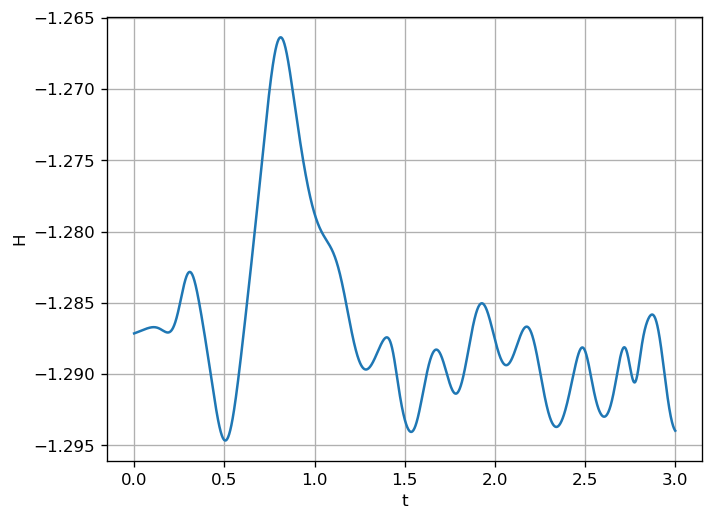

In [22]:
state = coords2state_3body(trajectory)
H_t = total_energy(state)

np.save("experiments/three-body/energy_vs_time.npy", H_t)

plt.figure(dpi=120)
plt.plot(t_eval, H_t)
plt.xlabel("t"); plt.ylabel("H")
plt.grid(True)
plt.show()

In [23]:
# === Compute ground truth trajectory === #

state_true_init = figure8_config()
#state_true_init = brouckeA1_config()
orbit_true, settings = get_orbit(state_true_init, t_points=num_steps, t_span=[0, T])
print(orbit_true.shape)

100%|██████████| 2999/2999 [00:01<00:00, 2752.32it/s]

(3, 5, 3000)


### Plot ground truth orbit vs predicted orbit vs energy comparison

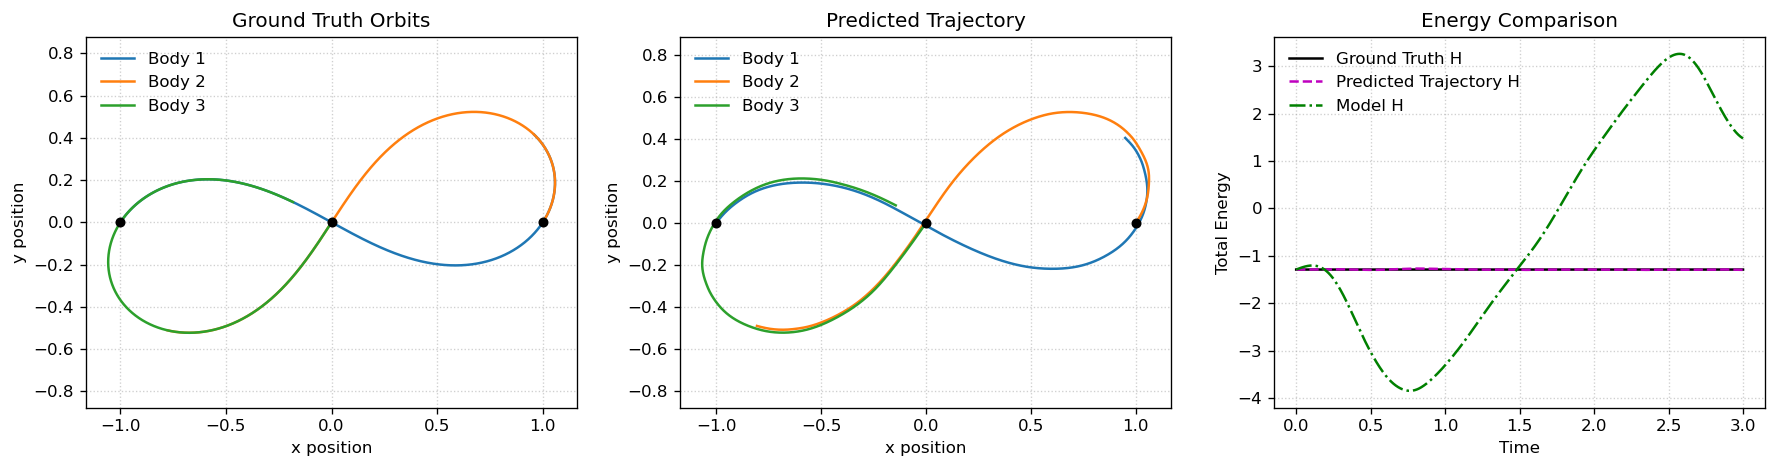

In [24]:
trajectory_pred = trajectory # Predicted orbit (already computed earlier)

# --- Make 3 subplots (True Orbit | Predicted Orbit | Energy Comparison) ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), dpi=120)

# --- TRUE ORBIT ---
ax1.plot(orbit_true[0,1], orbit_true[0,2], label='Body 1')
ax1.plot(orbit_true[1,1], orbit_true[1,2], label='Body 2')
ax1.plot(orbit_true[2,1], orbit_true[2,2], label='Body 3')
ax1.scatter(orbit_true[0,1,0], orbit_true[0,2,0], c='k', s=25, zorder=5) # Starting point body 1
ax1.scatter(orbit_true[1,1,0], orbit_true[1,2,0], c='k', s=25, zorder=5) # Starting point body 2
ax1.scatter(orbit_true[2,1,0], orbit_true[2,2,0], c='k', s=25, zorder=5) # Starting point body 3
ax1.set_title('Ground Truth Orbits')
ax1.set_xlabel('x position'); ax1.set_ylabel('y position')
ax1.axis('equal'); ax1.legend(frameon=False); ax1.grid(True, linestyle=':', alpha=0.6)

# --- PREDICTED ORBIT ---
ax2.plot(trajectory_pred[:,0], trajectory_pred[:,3], label='Body 1')
ax2.plot(trajectory_pred[:,1], trajectory_pred[:,4], label='Body 2')
ax2.plot(trajectory_pred[:,2], trajectory_pred[:,5], label='Body 3')


ax2.scatter(trajectory_pred[0,0], trajectory_pred[0,3], c='k', s=25, zorder=5) # Starting point body 1
ax2.scatter(trajectory_pred[0,1], trajectory_pred[0,4], c='k', s=25, zorder=5) # Starting point body 2
ax2.scatter(trajectory_pred[0,2], trajectory_pred[0,5], c='k', s=25, zorder=5) # Starting point body 2
ax2.set_title(f'Predicted Trajectory')
ax2.set_xlabel('x position'); ax2.set_ylabel('y position')
ax2.axis('equal'); ax2.legend(frameon=False); ax2.grid(True, linestyle=':', alpha=0.6)

t_eval_pred = np.linspace(0, T, num_steps + 1)
t_eval_true = np.linspace(0, T, orbit_true.shape[2])

# --- ENERGY COMPARISON ---
t_eval = np.linspace(0, T, orbit_true.shape[2])
etot_true = total_energy(orbit_true)
state_pred = coords2state_3body(trajectory_pred)
etot_pred = total_energy(state_pred)
etot_pred = etot_pred[:len(t_eval)]  # match lengths

# Make sure we're comparing the same time range
min_time_points = min(len(t_eval_true), len(t_eval_pred), len(etot_pred))
t_eval_common = t_eval_true[:min_time_points]  # Use true time as reference

ax3.plot(t_eval_common, etot_true[:min_time_points], 'k-', lw=1.5, label='Ground Truth H')
ax3.plot(t_eval_common, etot_pred[:min_time_points], 'm--', lw=1.5, label=f'Predicted Trajectory H')

# ===  Add model's own predicted Hamiltonian output overlay ===

if kwargs["model"] != "S-MLP" and kwargs["model"] != "MLP" :
    H_pred = []
    for x in trajectory_pred:
        if getattr(model, "is_torch_model", False):
            x_t = torch.tensor(x[None, :], dtype=torch.float64)
            with torch.no_grad():
                H_pred.append(model.H(x_t).item())
        else:
            H_pred.append(model.H(x[None, :]))

    H_pred = np.array(H_pred).flatten()
    C = etot_true[0] - H_pred[0]
    H_pred_aligned = H_pred + C


min_len_h = min(len(t_eval_common), len(H_pred_aligned))
ax3.plot(t_eval_common[:min_len_h], H_pred_aligned[:min_len_h], 'g-.', lw=1.5, label='Model H')

ax3.set_title('Energy Comparison')
ax3.set_xlabel('Time'); ax3.set_ylabel('Total Energy')
ax3.legend(frameon=False); ax3.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.savefig("plots/fig8_s_hnn_midpoint_full.png", dpi=300)
plt.show()

### Plot predicted trajectory's position error over time

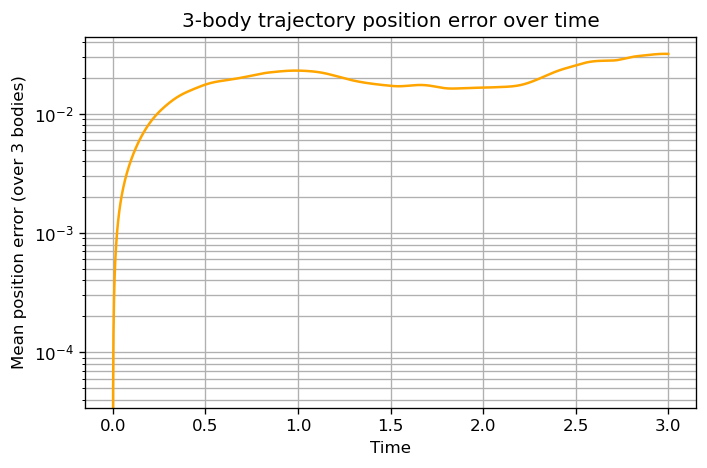

Mean error: 0.019378360652362148
Final error: 0.03184350982270999


In [25]:
def interp_traj(traj_TxD, t_src, t_tgt):
    traj_TxD = np.asarray(traj_TxD)
    t_src = np.asarray(t_src)
    t_tgt = np.asarray(t_tgt)

    if traj_TxD.shape[0] != len(t_src):
        raise ValueError(f"traj_TxD has T={traj_TxD.shape[0]} but t_src has len={len(t_src)}")

    out = np.empty((len(t_tgt), traj_TxD.shape[1]), dtype=traj_TxD.dtype)
    for d in range(traj_TxD.shape[1]):
        out[:, d] = np.interp(t_tgt, t_src, traj_TxD[:, d])
    return out

def mean_pos_error_3body(traj_true_Tx12, traj_pred_Tx12):
    # positions are [qx1,qx2,qx3,qy1,qy2,qy3]
    q_true = traj_true_Tx12[:, 0:6].reshape(-1, 3, 2)  # (T,3,2)
    q_pred = traj_pred_Tx12[:, 0:6].reshape(-1, 3, 2)  # (T,3,2)
    per_body = np.linalg.norm(q_pred - q_true, axis=2)  # (T,3)
    return per_body.mean(axis=1)  # (T,)


# Make sure pred traj and pred time are aligned
Tpred = trajectory_pred.shape[0]
if len(t_eval_pred) != Tpred:
    raise ValueError(f"trajectory_pred has {Tpred} steps but t_eval_pred has {len(t_eval_pred)} times")

# --- Use the overlapping time interval ---
t_end = min(t_eval_true[-1], t_eval_pred[-1])
t_eval_common = t_eval_pred[t_eval_pred <= t_end]

# --- True trajectory -> coords12 -> interpolate onto common grid ---
traj_true_coords = orbit_state_to_coords12(orbit_true)  # (Ttrue,12)
traj_true_on_common = interp_traj(traj_true_coords, t_eval_true, t_eval_common)

# --- Pred trajectory on same common grid ---
idx = np.searchsorted(t_eval_pred, t_eval_common)  # robust even if mask/indexing gets weird
traj_pred_on_common = trajectory_pred[idx, :]

# --- Compute error ---
pos_err = mean_pos_error_3body(traj_true_on_common, traj_pred_on_common)
np.save("experiments/three-body/pos_err_s_hnn.npy", pos_err)

# --- Plot ---
plt.figure(figsize=(6, 4), dpi=120)
plt.plot(t_eval_common, pos_err, color="orange")
plt.yscale("log")  # optional; comment out if you want linear
plt.xlabel("Time")
plt.ylabel("Mean position error (over 3 bodies)")
plt.title("3-body trajectory position error over time")
plt.grid(True, which="both")
plt.tight_layout()
plt.show()

print("Mean error:", float(np.mean(pos_err)))
print("Final error:", float(pos_err[-1]))


### Energy comparison S-HNN vs S-MLP vs HNN vs MLP

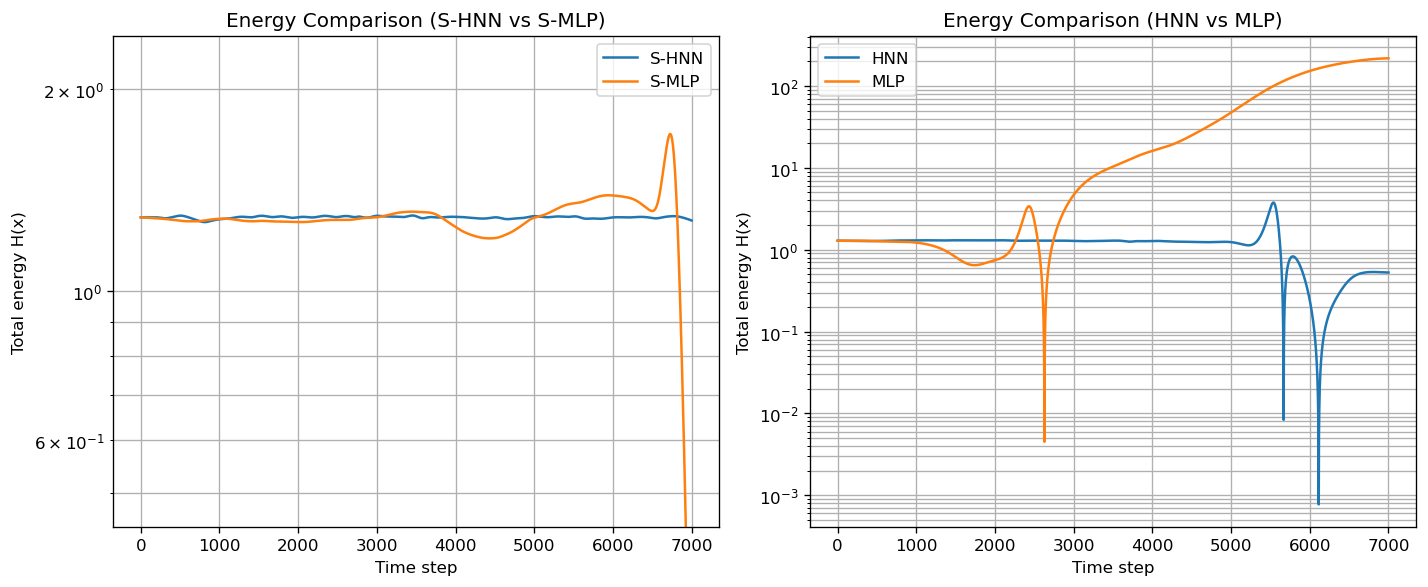

In [26]:
total_energy_hnn = np.load("experiments/three-body/total_energy_hnn.npy")
total_energy_s_hnn = np.load("experiments/three-body/total_energy_s_hnn.npy")
total_energy_mlp = np.load("experiments/three-body/total_energy_mlp.npy")
total_energy_s_mlp = np.load("experiments/three-body/total_energy_s_mlp.npy")
t = np.arange(len(total_energy_hnn))
fig, axes = plt.subplots(1, 2, figsize=(12,5), dpi=120)
# --- Left: S-HNN vs S-MLP (ZOOMED) ---
axes[0].semilogy(t, np.abs(total_energy_s_hnn), label="S-HNN")
axes[0].semilogy(t, np.abs(total_energy_s_mlp), label="S-MLP")
axes[0].set_title("Energy Comparison (S-HNN vs S-MLP)")
axes[0].set_xlabel("Time step")
axes[0].set_ylabel("Total energy H(x)")
axes[0].legend()
axes[0].grid(True, which="both") # zoom limits based only on these two
ymin_left = min(np.min(np.abs(total_energy_s_hnn)), np.min(np.abs(total_energy_s_mlp)))
ymax_left = max(np.max(np.abs(total_energy_s_hnn)), np.max(np.abs(total_energy_s_mlp)))
axes[0].set_ylim(ymin_left*3, ymax_left*1.4)
# --- Right: HNN vs MLP (FULL SCALE) ---
axes[1].semilogy(t, np.abs(total_energy_hnn), label="HNN")
axes[1].semilogy(t, np.abs(total_energy_mlp), label="MLP")
axes[1].set_title("Energy Comparison (HNN vs MLP)")
axes[1].set_xlabel("Time step")
axes[1].legend()
axes[1].grid(True, which="both")
axes[1].set_ylabel("Total energy H(x)")
plt.tight_layout()
plt.show()